# 2022-04-11 Integration

## Last time

* Reflect on differentiation
* Second order (Newton type) optimization
* Project discussion

## Today

* Midpoint and trapezoid rules
* Extrapolation
* Polynomial interpolation for integration

In [27]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

CosRange (generic function with 1 method)

# Integration

We're interested in computing definite integrals

$$ \int_a^b f(x) dx $$

and will usually consider finite domains $-\infty < a <b < \infty$.

* Cost: (usually) how many times we need to evaluate the function $f(x)$
* Accuracy
  * compare to a reference value
  * compare to the same method using more evaluations
* Consideration: how smooth is $f$?

# We need some test functions

In [2]:
F_expx(x) = exp(2x) / (1 + x^2)
f_expx(x) = 2*exp(2x) / (1 + x^2) - 2x*exp(2x)/(1 + x^2)^2

F_dtanh(x) = tanh(x)
f_dtanh(x) = cosh(x)^-2

integrands = [f_expx, f_dtanh]
antiderivatives = [F_expx, F_dtanh]
tests = zip(integrands, antiderivatives)

zip(Function[f_expx, f_dtanh], Function[F_expx, F_dtanh])

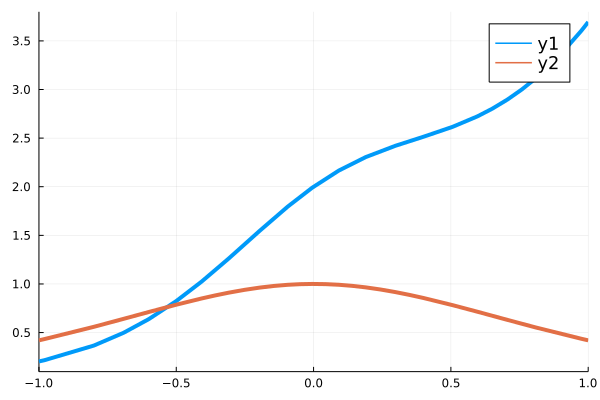

In [3]:
plot(integrands, xlims=(-1, 1))


## Fundamental Theorem of Calculus

Let $f(x)$ be a continuous function and define $F(x)$ by
$$ F(x) = \int_a^x f(s) ds . $$
Then $F(x)$ is uniformly continuous, differentiable, and
$$ F'(x) = f(x) . $$
We say that $F$ is an antiderivative of $f$.
This implies that
$$ \int_a^b f(x) dx = F(b) - F(a) . $$
We will test the accuracy of our integration schemes using an antiderivative provided in our tests.

### Method of Manufactured Solutions

* Analytically integrating an arbitrary function is hard
  * tends to require trickery
  * not always possible to express in closed form (e.g., [elliptic integrals](https://en.wikipedia.org/wiki/Elliptic_integral))
  * sometimes needs special functions $\operatorname{erf} x = \frac{2}{\sqrt\pi} \int_0^x e^{-t^2} dt$
  * don't know when to give up
  
* Analytic differentation
  * involves straightforward application of the product rule and chain rule.
  
So if we just choose an arbitrary function $F$ (the antiderivative), we can

1. compute $f = F'$
2. numerically integrate $\int_a^b f$ and compare to $F(b) - F(a)$

# Newton-Cotes methods

Approximate $f(x)$ using piecewise polynomials (an interpolation problem) and integrate the polynomials.

### Midpoint method

In [4]:
function fint_midpoint(f, a, b; n=20)
    dx = (b - a) / n
    x = LinRange(a + dx/2, b - dx/2, n)
    sum(f.(x)) * dx
end

for (f, F) in tests
    a, b = -2, 2
    I_num = fint_midpoint(f, a, b, n=20)
    I_analytic = F(b) - F(a)
    println("$f: $I_num error=$(I_num - I_analytic)")
end

f_expx: 10.885522849146847 error=-0.03044402970425253
f_dtanh: 1.9285075531458646 error=0.00045239299423083246


# How does the accuracy change as we use more points?

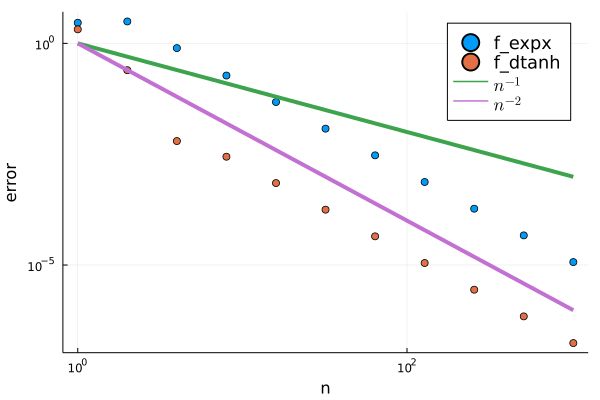

In [5]:
function plot_accuracy(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error")
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    for k in ref
        plot!(ns, ns.^(-1. * k), label="\$n^{-$k}\$")
    end
    p
end
plot_accuracy(fint_midpoint, tests, 2 .^ (0:10))

## Trapezoid Rule

The trapezoid rule uses piecewise linear functions on each interval.

$$\begin{split} \int_a^b f(a) + \frac{f(b) - f(a)}{b - a} (x - a) &= f(a) (x-a) + \frac{f(b) - f(a)}{2(b - a)} (x - a)^2 \Big|_{x=a}^b \\
&= f(a) (b-a) + \frac{f(b) - f(a)}{2(b - a)} (b-a)^2 \\
&= \frac{b-a}{2} \big( f(a) + f(b) \big) .
\end{split} $$

* Can you get to the same result using a geometric argument?
* What happens when we sum over a bunch of adjacent intervals?

# Trapezoid in code

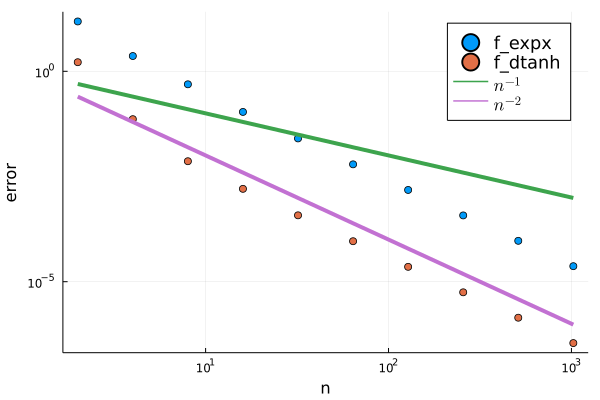

In [6]:
function fint_trapezoid(f, a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[1] /= 2
    fx[end] /= 2
    sum(fx) * dx
end

plot_accuracy(fint_trapezoid, tests, 2 .^ (1:10))

## Extrapolation

Let's switch our plot around to use $h = \Delta x$ instead of number of points $n$.

In [16]:
function plot_accuracy_h(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="h", ylabel="error",
        legend=:bottomright)
    hs = (b - a) ./ ns
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(hs, Errors, label=f)
    end
    for k in ref
        plot!(hs, hs.^k, label="\$h^{$k}\$")
    end
    p
end


plot_accuracy_h (generic function with 1 method)

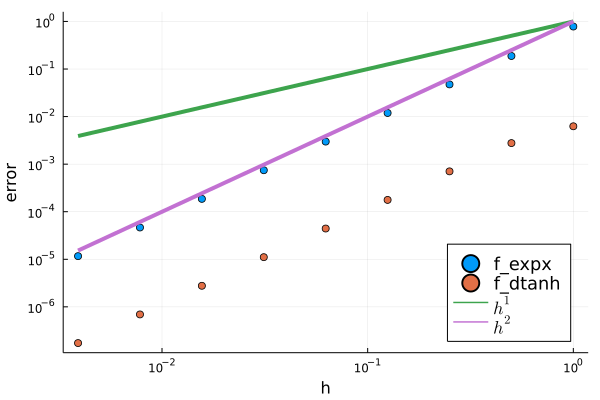

In [17]:
plot_accuracy_h(fint_midpoint, tests, 2 .^ (2:10))

# Extrapolation math
The trapezoid rule with $n$ points has an interval spacing of $h = 1/(n-1)$.  Let $I_h$ be the value of the integral approximated using an interval $h$.  We have numerical evidence that the leading error term is $O(h^2)$, i.e.,
$$ I_h - I_0 = c h^2 + O(h^3) $$
for some as-yet unknown constant $c$ that will depend on the function being integrated and the domain of integration.
If we can determine $c$ from two approximations, say $I_h$ and $I_{2h}$, then we can extrapolate to $h=0$.
For sufficiently small $h$, we can neglect $O(h^3)$ and write
$$\begin{split} I_h - I_0 &= c h^2 \\
I_{2h} - I_0 &= c (2h)^2 .
\end{split}$$
Subtracting these two lines, we have
$$ I_{h} - I_{2h} = c (h^2 - 4 h^2) $$
which can be solved for $c$ as
$$ c = \frac{I_{h} - I_{2h}}{h^2 - 4 h^2} . $$
Substituting back into the first equation, we solve for $I_0$ as
$$ I_0 = I_h - c h^2 = I_h + \frac{I_{h} - I_{2h}}{4 - 1} .$$
This is called **Richardson extrapolation**.

# Extrapolation code

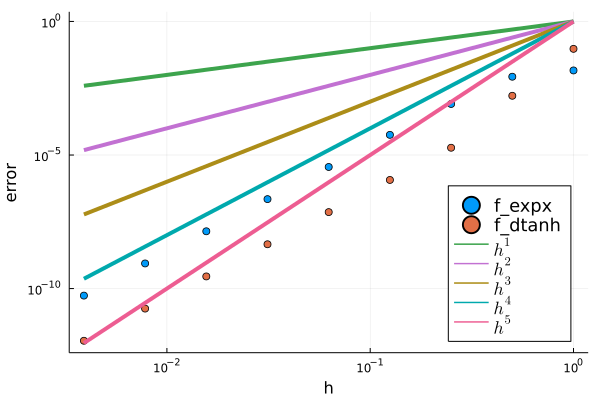

In [24]:
function fint_richardson(f, a, b; n=20)
    n = div(n, 2) * 2 + 1
    h = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[[1, end]] /= 2
    I_h = sum(fx) * h
    I_2h = sum(fx[1:2:end]) * 2h
    I_h + (I_h - I_2h) / 3
end
plot_accuracy_h(fint_richardson, tests, 2 .^ (2:10), ref=1:5)

* we now have a sequence of accurate approximations
* it's possible to apply extrapolation recursively
* works great if you have a power of 2 number of points
  * and your function is nice enough

# Polynomial interpolation for integration

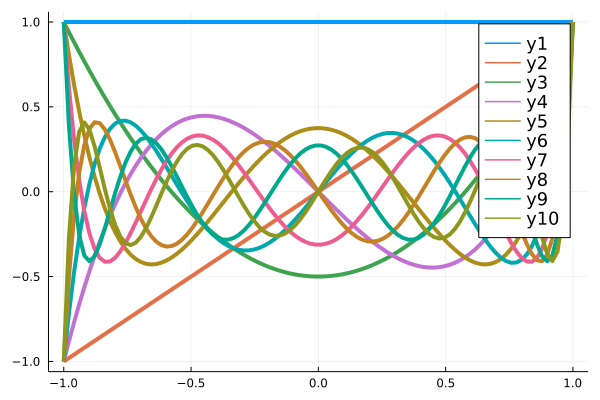

In [28]:
x = LinRange(-1, 1, 100)
P = vander_legendre(x, 10)
plot(x, P)

## Idea

* Sample the function $f(x)$ at some points $x \in [-1, 1]$
* Fit a polynomial through those points
* Return the integral of that interpolating polynomial

## Question

* What points do we sample on?
* How do we integrate the interpolating polynomial?

Recall that the Legendre polynomials $P_0(x) = 1$, $P_1(x) = x$, ..., are pairwise orthogonal

$$\int_{-1}^1 P_m(x) P_n(x) = 0, \quad \forall m\ne n.$$

# Integration using Legendre polynomials

In [36]:
function plot_accuracy_n(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error",
        legend=:bottomright)
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    p
end

plot_accuracy_n (generic function with 1 method)

In [53]:
function fint_legendre(f, a, b; n=20)
    x = CosRange(-1, 1, n)
    P = vander_legendre(x)
    x_ab = (a+b)/2 .+ (b-a)/2*x
    c = P \ f.(x_ab)
    (b - a) * c[1]
end

fint_legendre(x -> 1 + x, -1, 1, n=4)

2.0

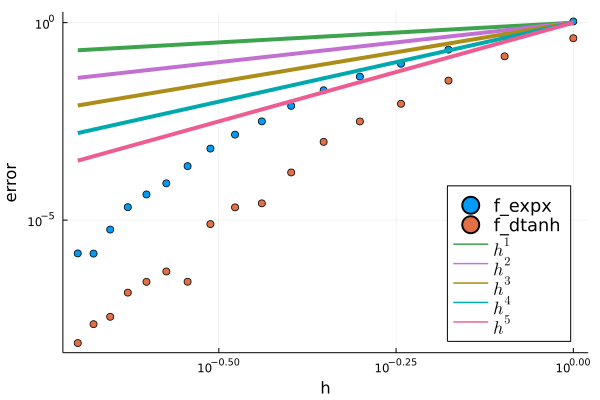

In [56]:
p = plot_accuracy_h(fint_legendre, tests, 4:20, ref=1:5)